# Content Based 3d Model Retrieval

Look at the data. Taken from: http://modelnet.cs.princeton.edu/

This data is in Object File Format (.off) There exist matlab tools to process these. Are they available in python? 

##### off files are ascii

make sure when writing you use
https://stackoverflow.com/questions/46850103/writing-to-files-in-ascii-with-python3-not-utf8

### How are voxels counted? 
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

##### Coordinates

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

from off_utils import (check_header,
                       parse_vertices_faces_edges,
                       load_off_file,
                       parse_coordinates,
                       parse_face_indeces)

a = load_off_file('sample.off')
coordinates = parse_coordinates(a)
face_indeces = parse_face_indeces(a)

# print('Coordinates')
# print(coordinates)
# print('\nFace Indeces')
# print(face_indeces)

In [13]:
face = coordinates[face_indeces[:, 1:][0], :]

In [34]:
coordinates

array([[-0.5, -0.5,  0.5],
       [ 0.5, -0.5,  0.5],
       [-0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [-0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5]])

##### let's try shapely first https://github.com/Toblerity/Shapely

In [35]:
from shapely.geometry import mapping, shape

###### Try matplotlib Polygon

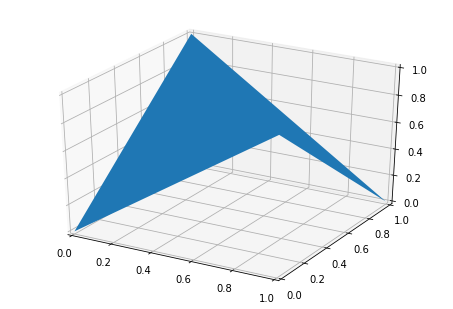

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = Axes3D(fig)

x = [0, 1, 1, 0]
y = [0, 0, 1, 1]
z = [0, 1, 0, 1]
vertices = [list(zip(x, y, z))]

ax.add_collection3d(Poly3DCollection(vertices))
plt.show()

###### plotting 3d sinewave

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2+Y**2)
Z = .1 * np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Evaluate class balance for ModelNet10 and ModelNet40

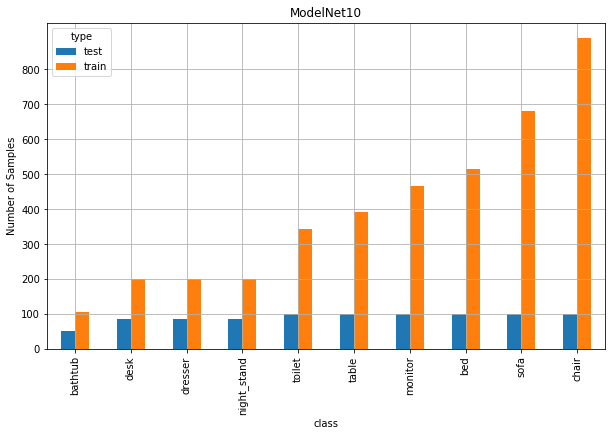

type,test,train
class,,
bathtub,50,106
desk,86,200
dresser,86,200
night_stand,86,200
toilet,100,344
table,100,392
monitor,100,465
bed,100,515
sofa,100,680


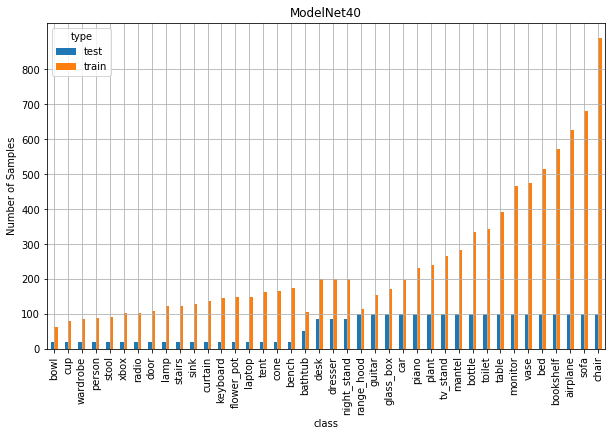

type,test,train
class,,
bowl,20,64
cup,20,79
wardrobe,20,87
person,20,88
stool,20,90
xbox,20,103
radio,20,104
door,20,109
lamp,20,124


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from count_files import (make_file_description_data_frame,
                         plot_class_balance)

df = make_file_description_data_frame('./ModelNet10/', show_missed=False)
plot_class_balance(df, 'ModelNet10')

df = make_file_description_data_frame('./ModelNet40/', show_missed=False)
plot_class_balance(df, 'ModelNet40')

# Appendix:

##### To better undrstand capsule nets

In [2]:
import numpy as np